In [1]:
from matplotlib import pyplot as plt
import jax.numpy as np
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as onp
from scipy.linalg import expm
from jax import jit, grad, value_and_grad, vmap
#from time import time
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit.providers.aer.pulse_new.de.DE_Problems import BMDE_Problem
from qiskit.providers.aer.pulse_new.de.DE_Solvers import BMDE_Solver
from qiskit.providers.aer.pulse_new.de.DE_Options import DE_Options
from qiskit.providers.aer.pulse_new.models.signals import VectorSignal, Constant, Signal
from qiskit.providers.aer.pulse_new.models.operator_models import OperatorModel

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

# 0. Notebook purpose

Demonstrates the conversion of the repository to using `jax`:
- Works with minimal changes to existing code
- `jax` can compile code
- `jax` can automatically differentiate code (plus simple optimization demonstration)

List of changes required to underlying code for basic functionality:
- Change all `numpy` imports to `jax.numpy` in all files
- Changed an `if` statement due to a difference between how `numpy` and `jax.numpy` compare arrays
- Re-added import of standard `numpy` in one place when instantiating `Operator` objects as they require standard `numpy` arrays

# 1. Verify basic `OperatorModel` and `Signal` functionality

Construct signals and a model and make sure it works.

In [2]:
w = 5.
r = 0.02

signals = [Constant(1.), Signal(1., w)]
operators = [-1j * 2 * np.pi * w * Z / 2, -1j * 2 * np.pi * r * X / 2]
generator = OperatorModel(signals=signals, operators=operators)

/opt/anaconda3/envs/devEnv/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### 1.1 Evaluate generator and compare to expected value

In [3]:
generator.evaluate(1.)

DeviceArray([[0.-15.70796327j, 0. -0.06283185j],
             [0. -0.06283185j, 0.+15.70796327j]], dtype=complex128)

Expected value:

In [4]:
gen_at_1 = -1j * 2 * np.pi * w * Z / 2 + onp.cos(2 * np.pi * w * 1.) *(-1j * 2 * np.pi * r * X / 2)
print(gen_at_1)

Operator([[0.-15.70796327j, 0. -0.06283185j],
          [0. -0.06283185j, 0.+15.70796327j]],
         input_dims=(2,), output_dims=(2,))


### 1.2 Evaluate generator in drift frame and compare to expected value

In [5]:
generator.frame = generator.drift
generator.evaluate(1.)

DeviceArray([[ 0.00000000e+00+0.j        , -7.69468277e-17-0.06283185j],
             [ 7.69468277e-17-0.06283185j,  0.00000000e+00+0.j        ]],            dtype=complex128)

Expected value:

In [6]:
F = (-1j * 2 * np.pi * w * Z / 2).data
expm(-F) @ gen_at_1.data @ expm(F) - F

array([[ 0.00000000e+00+0.j        , -7.69468277e-17-0.06283185j],
       [ 7.69468277e-17-0.06283185j,  0.00000000e+00+0.j        ]])

# 2. Verify just in time compilation (`jax.jit`)

Here we want to make sure just in time compilation "just works" with what we have set up.

First `jit` and measure time of first evaluation

In [7]:
fast_evaluate = jit(lambda t: generator.lmult(t, np.array([1., 0.])))

print("Speed of first evaluation with compilation:")
print("-------------------------------------------")
%time res = fast_evaluate(1.).block_until_ready()

Speed of first evaluation with compilation:
-------------------------------------------
CPU times: user 357 ms, sys: 84.9 ms, total: 442 ms
Wall time: 56.5 ms


Now evaluate compare speed of `jit`ed function and non-`jit`ed

In [8]:
t = 4.

print("Speed of uncompiled function:")
print("-----------------------------")
%time res1 = generator.evaluate(t).block_until_ready()

print("\nSpeed of compiled function after first evaluation:")
print("--------------------------------------------------")
%time res2 = fast_evaluate(t).block_until_ready()

print("\nComparison of outputs:")
print("----------------------")
print(res1 - res2)

Speed of uncompiled function:
-----------------------------
CPU times: user 22.5 ms, sys: 12.7 ms, total: 35.2 ms
Wall time: 4.42 ms

Speed of compiled function after first evaluation:
--------------------------------------------------
CPU times: user 4.01 ms, sys: 2.32 ms, total: 6.33 ms
Wall time: 841 µs

Comparison of outputs:
----------------------
[[ 0.00000000e+00+0.j         -6.15574622e-16+0.j        ]
 [ 3.07787311e-16-0.06283185j -3.07787311e-16+0.06283185j]]


### Notes
- Amazingly, the standard `numpy` implementation is actually _faster_ than the `jit`-ed `jax` version. The `numpy` version takes about 300 microseconds to do `lmult`. I wonder if this has anything to do with `jit` trying to utilize multiple cores even for this.
    - In a way this point is moot anyway as the compiled solver is so much faster than `numpy`/`scipy` 

# 3. Solving with `jax`-based solver

In this section we solve the above model using a DE method currently available in `jax`.

For this section, we have added a new `ODE_Method` to `DE_Methods.py` that calls the `jax` solver. This required about 40 lines of code (including comments), and just follows the standardized procedure for adding a new underlying solver method. In this branch this method has been made the default.

### 3.1 Solving without RWA

In [9]:
def integrate_model(c, t):
    gen_copy = generator.copy() # make this a pure function
    
    gen_copy.signals = [Constant(1.), Signal(lambda t: c, w)]
    de_problem = BMDE_Problem(generator=gen_copy, y0=np.array([1., 0.]), t0=0.)
    options = DE_Options(atol=1e-10, rtol=1e-10)
    de_solver = BMDE_Solver(de_problem, options=options)
    de_solver.integrate(t)
    return de_solver.y

In [10]:
# jit and call once
fast_integrate = jit(integrate_model)

%time res = fast_integrate(1., 1./r).block_until_ready()

CPU times: user 937 ms, sys: 33.4 ms, total: 970 ms
Wall time: 876 ms


Speed after compilation.

In [11]:
c = 1.
t = 2./r
print("\nSpeed of compiled function after first evaluation:")
print("--------------------------------------------------")
%time res = fast_integrate(c, t).block_until_ready()


Speed of compiled function after first evaluation:
--------------------------------------------------
CPU times: user 11.5 ms, sys: 1.25 ms, total: 12.7 ms
Wall time: 10.8 ms


### Notes:
- Using standard `numpy` and `scipy` integrate, this takes about `3.5` seconds. Hence, once compiled the `jax` solver is almost 3 orders of magnitude faster.

### 3.2 Solving with RWA

We can now run the same speed experiments but when solving using the RWA.

In [12]:
def integrate_model_rwa(c, t):
    gen_copy = generator.copy() # make this a pure function
    
    gen_copy.signals = [Constant(1.), Signal(lambda t: c, w)]
    de_problem = BMDE_Problem(generator=gen_copy, y0=np.array([1., 0.]), t0=0., cutoff_freq=2*w)
    options = DE_Options(atol=1e-10, rtol=1e-10)
    de_solver = BMDE_Solver(de_problem, options=options)
    de_solver.integrate(t)
    return de_solver.y

In [13]:
# jit and call once
fast_integrate_rwa = jit(integrate_model_rwa)

%time res = fast_integrate_rwa(1., 1./r).block_until_ready()

CPU times: user 909 ms, sys: 14.2 ms, total: 923 ms
Wall time: 911 ms


Speed after compilation.

In [14]:
c = 1.
t = 2./r

print("\nSpeed of compiled function after first evaluation:")
print("--------------------------------------------------")
%time res2 = fast_integrate_rwa(c, t).block_until_ready()

print(res2)


Speed of compiled function after first evaluation:
--------------------------------------------------
CPU times: user 833 µs, sys: 398 µs, total: 1.23 ms
Wall time: 491 µs
[-1.00000000e+00-1.01328277e-14j  3.14261418e-15+1.81838554e-11j]


### Notes:
- The pure `numpy`/`scipy` version of this simulation took about 25 ms. Hence, in this case, for a single simulation, it does outperform `jax`.
- The "uncompiled" cost is the same as the non-RWA case, which makes sense as whether the RWA is made or not won't change anything regarding compilation speed, which dominates this cost.

# 4. Automatic differentiation

Next we demonstrate using `jax`'s automatic differentiation through one of the above solving functions.

We compute the excited population at a given time, assuming the system is driven with a constant amplitude, and use `jax` to construct a variant of the function that computes both the function itself as well as the derivative with respect to time. 

Note: it is pretty cool that the time parameter can be differentiated as this defines the limits of integration.

In [15]:
def excited_population(t):
    return np.abs(integrate_model(1., t)[1])**2

excited_pop_grad = jit(value_and_grad(excited_population))

In [16]:
print("Speed of uncompiled function:")
print("-----------------------------")
%time res = excited_pop_grad(1./r)[1].block_until_ready()

Speed of uncompiled function:
-----------------------------
CPU times: user 1.76 s, sys: 28.1 ms, total: 1.79 s
Wall time: 1.77 s


In [17]:
print("\nSpeed of compiled function after first evaluation:")
print("--------------------------------------------------")
%time res = excited_pop_grad(2./r)[1].block_until_ready()


Speed of compiled function after first evaluation:
--------------------------------------------------
CPU times: user 10.6 ms, sys: 1.11 ms, total: 11.7 ms
Wall time: 9.69 ms


Next, plot the value of the excited population and its derivative for each length of time.

Plot the excited state population and its derivative
----------------------------------------------------


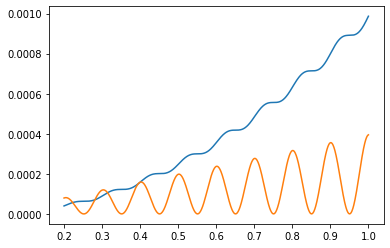

In [18]:
t_vals = np.linspace(0.2, 1., 1000)
#vals = vmap(grad_test)(t_vals)
#func_vals = vals[0]
#grad_vals = vals[1]
vals = [excited_pop_grad(t) for t in t_vals]
func_vals = np.array([entry[0] for entry in vals])
grad_vals = np.array([entry[1] for entry in vals])
print('Plot the excited state population and its derivative')
print('----------------------------------------------------')
plt.plot(t_vals, func_vals)
plt.plot(t_vals, grad_vals*0.1)

Observe: the oscillations are due to drift term causing constant spinning of the state around the $z$-axis (this calculation is done without the RWA).

# 6. Optimizing continuous pulses with variable integration length

Simple demonstration:
- Optimize a gaussian-shaped pulse to do a $\pi$-pulse.
   - Optimize over amplitude/std of gaussian
   - Length of pulse defined in terms of std to ensure start/end at $0$ amplitude.
- Nice feature of using a "fully `jax`" variable step size solver: 
   - optimize over class of smooth pulses defined as callable functions easily
   - optimize over a class of pulses with variable length (can differentiate through arbitrary args to the ode solver)

For this we need a couple of additional functions:
- `find_pulse_bfgs_parallel` 
    - Runs gradient descent BFGS algorithm in `scipy` on `jax`-differentiable function.
    - Parallelizes using `joblib` package.
- `diffeo` 
    - A convenience function for enforcing constraints

In [19]:
from qiskit.providers.aer.pulse_new.optimize.optimize import find_pulse_bfgs_parallel
from qiskit.providers.aer.pulse_new.optimize.opt_utils import diffeo

# we define the same model

w = 5.
r = 0.02

operators = [-1j * 2 * np.pi * w * Z / 2, 
             -1j * 2 * np.pi * r * X / 2]
generator = OperatorModel(operators=operators)

Define a Gaussian shape and a function that generates the signals for the models.

In [20]:
def gauss(amp, sigma, t0, t):
    return amp * np.exp(-(t - t0)**2 / (2 * sigma)**2)

def signal_generator(amp, sigma, T):
    centered_gauss = lambda t: gauss(amp, sigma, T/2, t)
    
    return [Constant(1.), Signal(centered_gauss, w)]

Define the objective to be optimized. The parameters will be the amplitude and STD $\sigma$ of the Gaussian. The time of the pulse will be set to $10 \times \sigma$ the STD, and the center of the Gaussian is set to half that.

We will attempt to optimize the excited state population, along with a time penalty to prefer shorter pulses.

In [21]:
# constraints
amp_max = 1.
sigma_max = 30.

def obj(params):
    # relate input parameters to their constrained values
    amp = diffeo(params[0], [-amp_max, amp_max])
    sigma = diffeo(params[1], [0., sigma_max])
    
    # set length of integration
    T = 10 * sigma
    
    # set up the generator
    gen_copy = generator.copy()
    gen_copy.signals = signal_generator(amp, sigma, T)
    
    # define and solve the problem, here we use the RWA
    de_problem = BMDE_Problem(generator=gen_copy, 
                      y0=np.array([1., 0.], dtype=complex),
                      t0=0.)
    options = DE_Options(atol=1e-8, rtol=1e-8)
    solver = BMDE_Solver(de_problem, options=options)
    solver.integrate(T)
    
    # return two pieces: 1-excited state population (it is a minimization)
    # and a term with the final time
    # we keep the final time coefficient small as we want to minimize it but value a higher fidelity 
    # operation
    return np.sqrt(1 - np.abs(solver.y[1])**2) + 1e-3 * T

Run the optimization

In [22]:
opt_shape = (2,) # the shape of the parameter space to optimize over
results = find_pulse_bfgs_parallel(obj, opt_shape, shots=8, n_jobs=8)

Total jobs: 8
Jobs completed: 8
Time taken: 20.215555906295776


Extract the best result (the results are already sorted according to objective value).

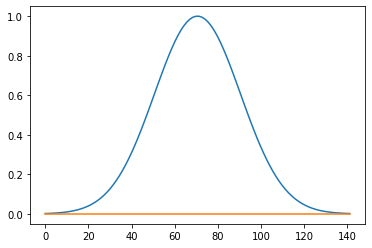

In [23]:
best_params = results[0].x
amp = diffeo(best_params[0], [-amp_max, amp_max])
sigma = diffeo(best_params[1], [0, sigma_max])
T = 10 * sigma

signals = signal_generator(amp, sigma, T)

signals[1].plot_envelope(0, T, 100)

We verify the correctness by integrating the area under the curve:

In [24]:
from scipy.integrate import quad
quad(signals[1].envelope, 0., T)[0]

49.99944599663545

For a $\pi$-pulse with this model the expected value is:

In [25]:
1/r

50.0

Investigate time of objective + gradient computation.

In [26]:
print('Time to construct gradient function and jit')
print('-------------------------------------------')
obj_grad = jit(value_and_grad(obj))
%time res = obj_grad(np.array([1., 2.]))[0].block_until_ready()

Time to construct gradient function and jit
-------------------------------------------
CPU times: user 3.15 s, sys: 42.8 ms, total: 3.19 s
Wall time: 3.17 s


In [27]:
print('Time to evaluate after compilation')
print('----------------------------------')
%time res = obj_grad(np.array([3., 2.]))[0].block_until_ready()

Time to evaluate after compilation
----------------------------------
CPU times: user 69.3 ms, sys: 1.11 ms, total: 70.4 ms
Wall time: 68.5 ms


# 7. `scipy` speed with compiled RHS

A final natural speed comparison is to see how fast the `scipy` integrator is when the RHS has been compiled using `jax`. (This will help determine how much of the long integration time in the `scipy` integrator is due to the RHS v.s. the integration algorithm itself.)

In [28]:
from scipy.integrate import solve_ivp
# set up the same model

w = 5.
r = 0.02

signals = [Constant(1.), Signal(1., w)]
operators = [-1j * 2 * np.pi * w * Z / 2, -1j * 2 * np.pi * r * X / 2]
generator = OperatorModel(signals=signals, operators=operators)
generator.frame = generator.drift

def rhs_func(t, y):
    return generator.lmult(t, y, in_frame_basis=True)

In [29]:
jit_rhs_func = jit(rhs_func)

# run once to force RHS compilation
jit_rhs_func(1., np.array([1., 0.]))

test_func = lambda t, y: onp.array(jit_rhs_func(t, np.array(y)) )

In [30]:
%time results = solve_ivp(test_func, (0., 1./r), np.array([1., 0.], dtype=complex), method='RK45', atol=1e-10, rtol=1e-10)

CPU times: user 12 s, sys: 1.46 s, total: 13.5 s
Wall time: 11.2 s


In [31]:
results.y[:, -1]

array([ 1.96347364e-07-5.00000436e-04j, -6.95870009e-13-9.99999875e-01j])

In [32]:
%time test_func(0.123, onp.array([1., 0.]))

CPU times: user 633 µs, sys: 212 µs, total: 845 µs
Wall time: 591 µs


array([-0.       +0.j        ,  0.0311682-0.03535339j])

In [33]:
generator.evaluate(1.)

DeviceArray([[ 0.00000000e+00+0.j        , -7.69468277e-17-0.06283185j],
             [ 7.69468277e-17-0.06283185j,  0.00000000e+00+0.j        ]],            dtype=complex128)